In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

nyse = pd.read_csv(r"/home/sombra/course/566/prices-split-adjusted.csv", parse_dates=['date'])

In [34]:
def init():
    palette = sns.color_palette('Set1')
    sns.set_palette('Set1')
    sns.set_context('notebook')
    sns.set_style('darkgrid')
    return palette

def benchmark(company, capital = 10000):
    company['daily_returns'] = company['close'].pct_change()
    company['daily_returns'].fillna(0, inplace=True)
    signals = pd.DataFrame(index=company.index)
    signals['benchmark'] = company['daily_returns'].cumsum() * capital + capital 
    return signals

def basic_strategy(company, short_lookback = 1, long_lookback = 20, capital = 10000, signals = None):


    signals['signal'] = 0.0

    signals['short_mav'] = company['close'].rolling(short_lookback,
                                                    min_periods=1,
                                                    center=False).mean()

    signals['long_mav'] = company['close'].rolling(long_lookback,
                                                min_periods=1,
                                                center=False).mean()
    
    signals['signal'][short_lookback:] = np.where(signals['short_mav'][short_lookback:] > signals['long_mav'][short_lookback:], 1.0, 0.0)
    signals['returns'] = (company['daily_returns'] * signals['signal']).cumsum() * capital + capital
    return signals

def basic_strategy_with_bollinger_bands(company, short_lookback = 1, long_lookback = 20, capital = 10000, signals = None):

    company['middle_bollinger_bands'] = signals['long_mav']
    standard_deviation = company['close'].rolling(long_lookback,
                                                min_periods=1,
                                                center=False).std()
    company['upper_bollinger_bands'] = company['middle_bollinger_bands'] + 2 * standard_deviation
    company['lower_bollinger_bands'] = company['middle_bollinger_bands'] - 2 * standard_deviation
    
    stop_profit = np.where(company['upper_bollinger_bands'] < signals['short_mav'], 0.0, 1.0)
    stop_loss = np.where(company['lower_bollinger_bands'] > signals['short_mav'], 0.0, 1.0)
    bollinger_bands_stop_signal = stop_profit * stop_loss
    true_stop_signal = (signals['signal'] == 1.0) & (bollinger_bands_stop_signal == 0.0)
    signals['signal_with_bollinger_bands'] = np.where(true_stop_signal, 0.0, signals['signal'])
    signals['returns_with_bollinger_bands'] = (company['daily_returns'] * signals['signal_with_bollinger_bands']).cumsum() * capital + capital
    return signals

def run_strategy(company, short_lookback = 1, long_lookback = 20, capital = 10000):
    signals = benchmark(company)
    signals = basic_strategy(company, signals=signals)
    signals = basic_strategy_with_bollinger_bands(company, signals=signals)
    return company, signals

def bollinger_bands_visualization(company, signals = None):
    fig, ax = plt.subplots(1,1, figsize=(16, 8))

    sns.lineplot(data=company['middle_bollinger_bands'], ax=ax, color=palette[1], label='Moving Average 20')
    sns.lineplot(data=company['upper_bollinger_bands'], ax=ax, color=palette[2], label='upper_bollinger_bands')
    sns.lineplot(data=company['lower_bollinger_bands'], ax=ax, color=palette[0], label='lower_bollinger_bands')
    sns.lineplot(data=company['close'], ax=ax, color=palette[-1], label='price')


    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title('Bollinger Bands')
    ax.set_ylabel('Price')
    ax.set_xlabel('Date')

    plt.show()

def return_visualization(company, signals):
    signals = benchmark(company)
    signals = basic_strategy(company, signals=signals)
    signals = basic_strategy_with_bollinger_bands(company, signals=signals)

    fig, ax = plt.subplots(1,1, figsize=(16, 8))

    sns.lineplot(data = signals['benchmark'], ax=ax, color=palette[-1], label='Benchmark')

    sns.lineplot(data = signals['returns'], ax=ax, color=palette[1], label='Algorithm')

    sns.lineplot(data = signals['returns_with_bollinger_bands'], ax=ax, color=palette[2], label='Algorithm with Bollinger Bands')

    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_title('Algorithm vs. Benchmark')
    ax.set_ylabel('Capital')
    ax.set_xlabel('Date')

    plt.show()

def trading_visualization(company, short_lookback = 1, long_lookback = 20, signals = None):
    signals['trading_point_with_bollinger_bands'] = signals['signal_with_bollinger_bands'].diff()



    fig, ax = plt.subplots(1,1, figsize=(16,8))

    sns.lineplot(y='short_mav', 
                x=signals.index, 
                data=signals, 
                
                ax=ax, 
                label=f'{short_lookback}-Day Moving Average',
                color=palette[-1])

    sns.lineplot(y='long_mav', 
                x=signals.index, 
                data=signals, 
                ax=ax, 
                label=f'{long_lookback}-Day Moving Average',
                color=palette[0])

    sns.lineplot(data=company['upper_bollinger_bands'], ax=ax, color=palette[2], label='upper_bollinger_bands')
    sns.lineplot(data=company['lower_bollinger_bands'], ax=ax, color=palette[3], label='lower_bollinger_bands')
    
    ax.plot(signals.loc[signals.trading_point_with_bollinger_bands == -1.0].index,                         
            signals.short_mav[signals.trading_point_with_bollinger_bands == -1.0],
            'v',                     
            markersize=5, 
            color=palette[0],
            label='Sell')

    ax.plot(signals.loc[signals.trading_point_with_bollinger_bands == 1.0].index,          
            signals.short_mav[signals.trading_point_with_bollinger_bands == 1.0],         
            '^', 
            markersize=5, 
            color=palette[2],
            label='Buy')

    ax.set_ylabel('Price')
    ax.set_xlabel('Date')
    ax.set_title('Trading Signals')
    plt.show()

def test_one(company):
    company, signals = run_strategy(company)
    bollinger_bands_visualization(company, signals=signals)
    trading_visualization(company, signals=signals)
    return_visualization(company, signals=signals)


palette = init()

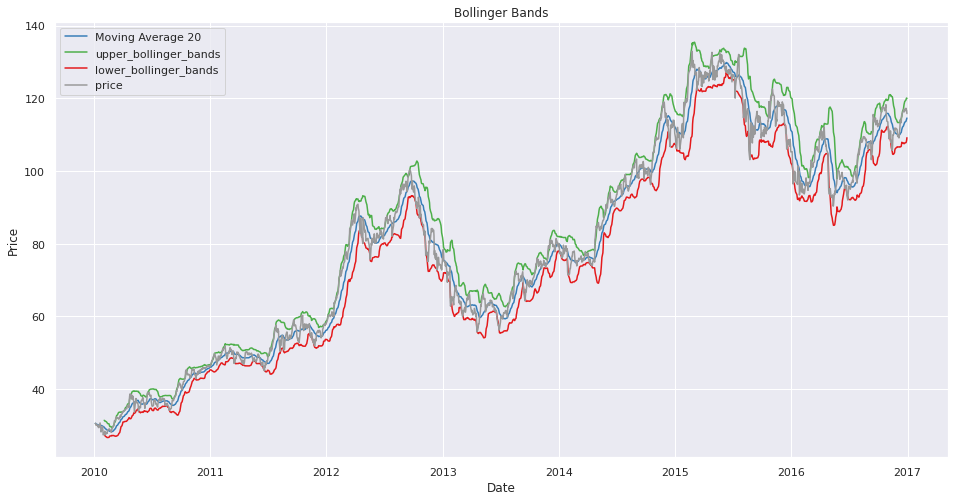

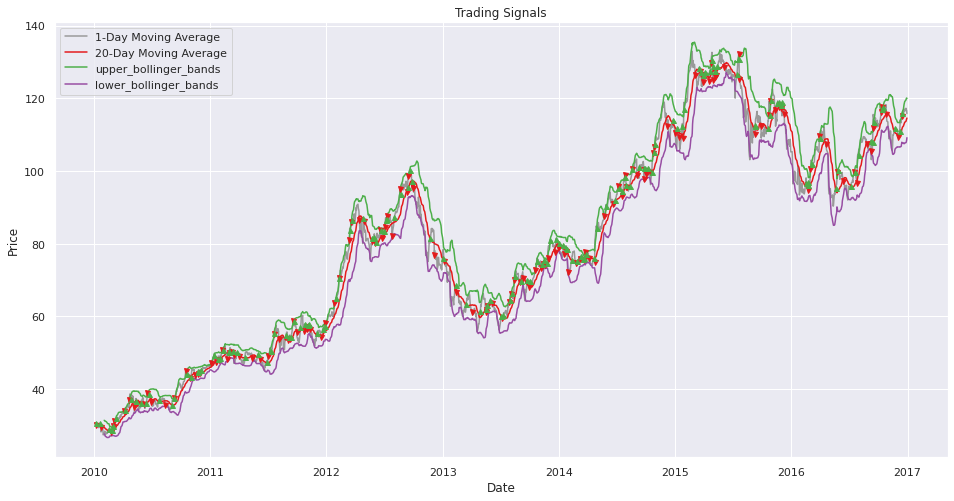

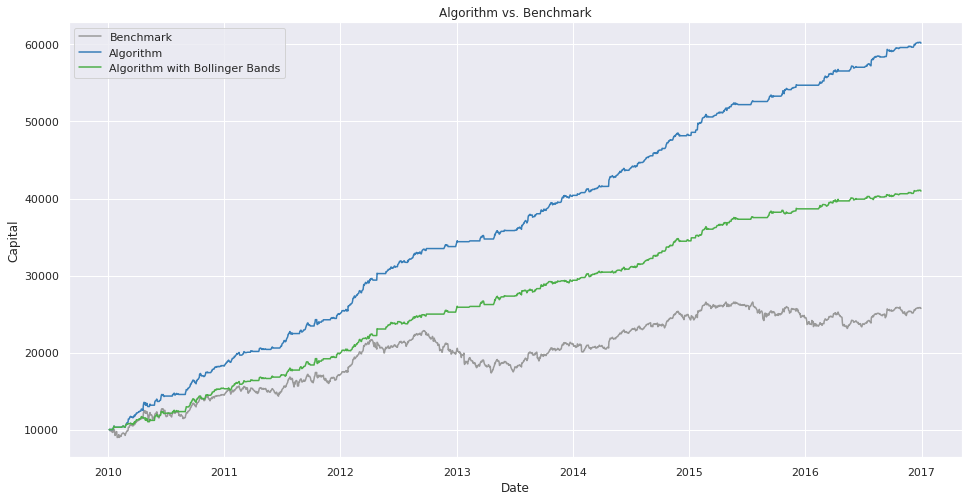

In [35]:
in_sample_company = nyse[nyse['symbol'] == 'AAPL'].set_index('date')
in_sample_company, signals = run_strategy(in_sample_company)
bollinger_bands_visualization(in_sample_company, signals=signals)
trading_visualization(in_sample_company, signals=signals)
return_visualization(in_sample_company, signals=signals)

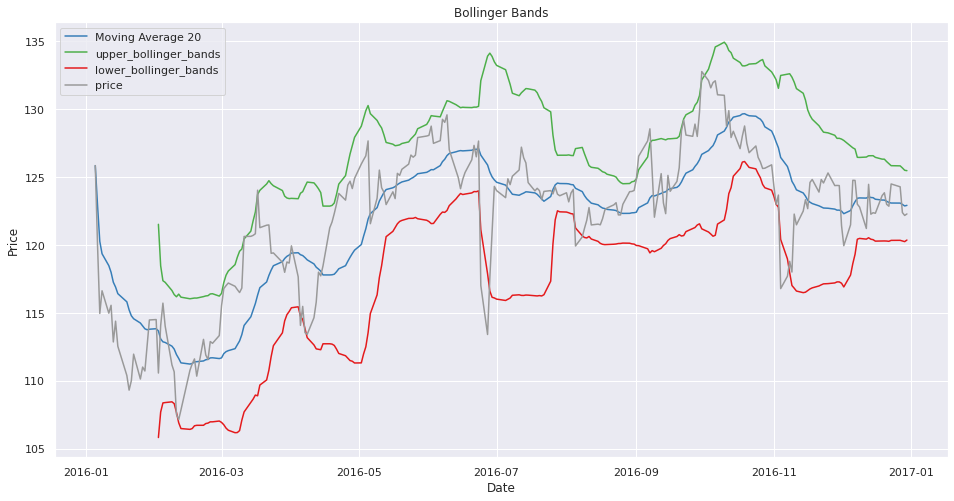

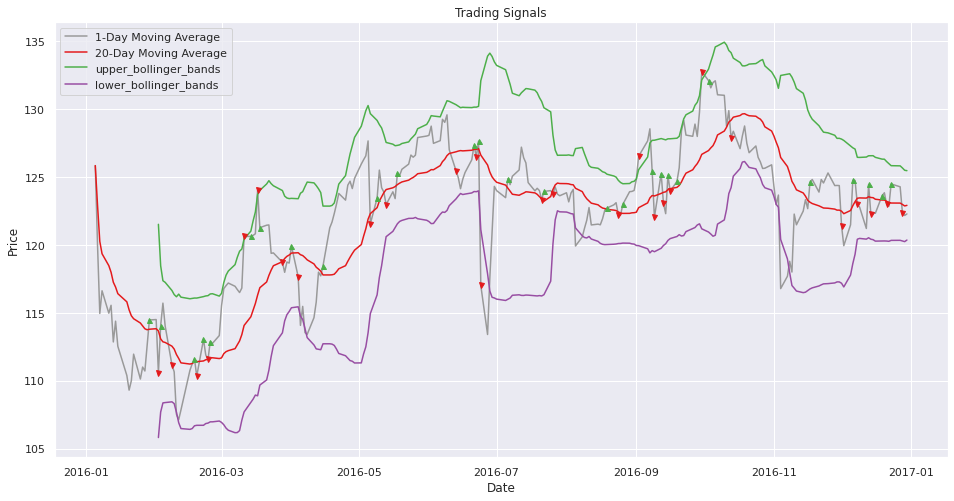

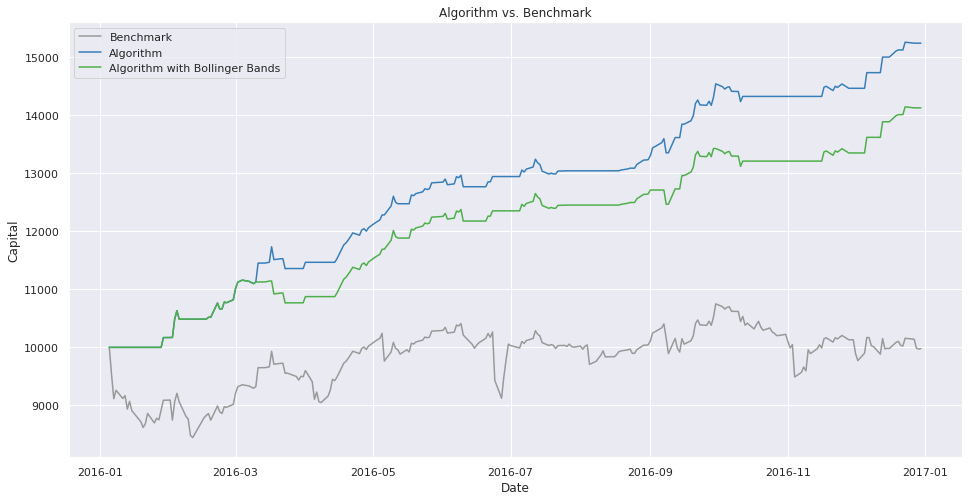

In [36]:
# Selecting company and calculating returns

test_company = nyse[nyse['symbol'] == 'WLTW'].set_index('date')

test_company, signals = run_strategy(test_company)

bollinger_bands_visualization(test_company, signals=signals)
trading_visualization(test_company, signals=signals)
return_visualization(test_company, signals=signals)


In [24]:
test_company_cases = nyse['symbol'].unique()